In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

In [ ]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [7]:
print(dataset_dir)
os.listdir(dataset_dir)

.\aclImdb


['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [12]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [13]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AttributeError: '_MapDataset' object has no attribute 'shape'

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - binary_accuracy: 0.5080 - loss: 0.6820 - val_binary_accuracy: 0.5788 - val_loss: 0.6136
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - binary_accuracy: 0.6298 - loss: 0.5801 - val_binary_accuracy: 0.7550 - val_loss: 0.4969
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - binary_accuracy: 0.7658 - loss: 0.4682 - val_binary_accuracy: 0.8034 - val_loss: 0.4226
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - binary_accuracy: 0.8222 - loss: 0.3967 - val_binary_accuracy: 0.8134 - val_loss: 0.3815
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - binary_accuracy: 0.8482 - loss: 0.3512 - val_binary_accuracy: 0.8454 - val_loss: 0.3486
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - binary_accuracy: 0.8710 - loss: 0.3173 - val_binary_accuracy: 0.8480 - val_loss: 0.3307
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - binary_accuracy: 0.8800 - loss: 0.2934 - val_binary_accuracy: 0.8592 - val_loss:

In [30]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - binary_accuracy: 0.7993 - loss: 0.3599
Loss:  0.3582834303379059
Accuracy:  0.8014400005340576


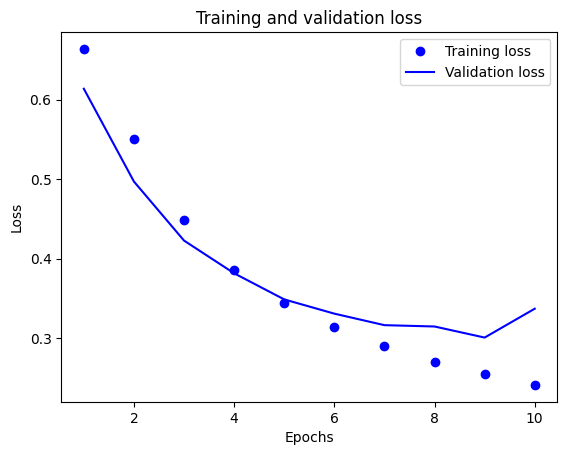

In [31]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

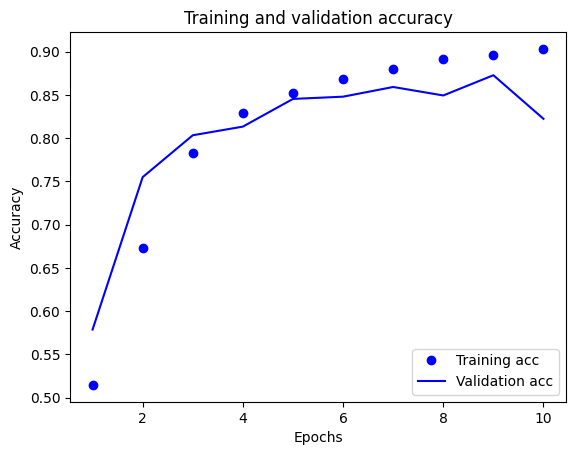

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8392 - loss: 0.3588
{'accuracy': 0.8375599980354309, 'loss': 0.35828331112861633}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


array([[0.21284248],
       [0.11309765],
       [0.07949466]], dtype=float32)